<a href="https://colab.research.google.com/github/lidaprogramer/Radiomics-feature-analysis-/blob/main/CinC2024_stenosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
   !pip install scikit-learn pandas matplotlib seaborn mrmr_selection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.0 MB/s eta 0:00:00


In [ ]:
 from google.colab import drive   #mounting the google drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from mrmr import mrmr_classif
from sklearn.utils import resample

In [ ]:
!pip install lckr-jupyterlab-variableInspector


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.3 MB/s eta 0:00:00


In [ ]:
print(locals())
print(globals())


{'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', "import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Step 10: Prepare data for visualization and plot 6 graphs in two rows\nfig, axes = plt.subplots(2, len(test_sizes), figsize=(11.69, 8.27), sharey=True)  # A4 landscape size\n\n# Common font properties for bold text\nfont_properties = {'fontsize': 14, 'fontweight': 'bold'}\n\n# Initialize a list to store the legend handles\nlegend_handles = []\n\n# Step 11: Loop through each test size and create a subplot for each in the appropriate row\nfor i, test_size in enumerate(test_sizes):\n    # Plotting for Correlation (first row)\n    filtered_corr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'Correlation')]\n    pivot_corr_df = filt

In [ ]:
#load the dataset

data_labeled_stenosis_file_path = '/content/drive/MyDrive/dataset1/data_labeled_stenosis.xlsx'

data = pd.read_excel(data_labeled_stenosis_file_path)

output_file_path = '/content/drive/MyDrive/dataset1/standardized_data.xlsx'
data1 =pd.read_excel(output_file_path)

In [ ]:
%whos


Variable                          Type         Data/Info
--------------------------------------------------------
LogisticRegression                type         <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
RandomForestClassifier            ABCMeta      <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SVC                               ABCMeta      <class 'sklearn.svm._classes.SVC'>
SelectKBest                       ABCMeta      <class 'sklearn.feature_s<...>e_selection.SelectKBest'>
StandardScaler                    type         <class 'sklearn.preproces<...>ng._data.StandardScaler'>
auc                               function     <function auc at 0x78afdd04b490>
data                              DataFrame         Unnamed: 0 coronary <...>\n[215 rows x 96 columns]
data1                             DataFrame        coronary  firstorder_<...>\n[215 rows x 94 columns]
data_labeled_stenosis_file_path   str          /content/drive/MyDrive/da<...>ata_labeled_stenosis.xlsx
dri

In [ ]:
# Step 2: Binarize the 'stenosis_score' column
data['stenosis_binary'] = data['stenosis_score'].apply(lambda x: 0 if x < 0.2 else 1)

# Step 3: Save the updated dataset (optional)
data.to_excel('/content/drive/MyDrive/dataset1/data_labeled_stenosis_binarized.xlsx', index=False)

# Display the first few rows of the updated dataset to verify the changes
print(data.head())

   Unnamed: 0 coronary  firstorder_10Percentile  firstorder_90Percentile  \
0           0    LAD_1                -0.149444                 0.254658   
1           1   LAD_2                 -0.582300                 0.088078   
2           2   LAD_3                 -0.666759                -0.559205   
3           3    LAD_4                -0.202232                -0.340271   
4           4    LAD_5                 0.557905                -0.140375   

   firstorder_Energy  firstorder_Entropy  firstorder_InterquartileRange  \
0          -0.139294            0.711191                       0.726062   
1           0.238828            0.996701                       0.496068   
2          -0.399217           -0.327179                      -0.106299   
3           1.869816           -0.077791                      -0.325342   
4           0.046783           -0.359706                      -0.369150   

   firstorder_Kurtosis  firstorder_Maximum  firstorder_MeanAbsoluteDeviation  \
0           

In [ ]:
# prepare the data
X = data1.iloc[: , 1:].values  # Features
y = data.iloc[:, -1].values   # Labels
feature_names = data1.columns[1:]  # Original feature names

In [ ]:
# define feature selection methods
def correlation_selector(X, y, k):
    cor_list = []
    for i in range(X.shape[1]):
        cor = np.corrcoef(X[:, i], y)[0, 1]
        cor_list.append(abs(cor))
    cor_list = np.nan_to_num(cor_list)  # Handle NaN values
    selected_indices = np.argsort(cor_list)[-k:]  # Select top k features
    return X[:, selected_indices], feature_names[selected_indices]  # Return the selected features and their names

def mrmr_selector(X, y, k):
    # mrmr_classif returns feature names, so we need to map them back to indices
    df = pd.DataFrame(X, columns=feature_names)  # Convert X to DataFrame for mrmr_classif
    selected_feature_names = mrmr_classif(X=df, y=pd.Series(y), K=k)
    selected_indices = [df.columns.get_loc(name) for name in selected_feature_names]
    return X[:, selected_indices], selected_feature_names  # Return the selected features and their names

feature_selection_methods = {
    'Correlation': correlation_selector,
    'MRMR': mrmr_selector
}

In [ ]:
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

In [ ]:
# bootstrap sampling and RSD calculation with different test sizes
bootstrap_iterations = 100  # Number of bootstrap samples
test_sizes = [0.2, 0.3, 0.4]  # Different test sizes to evaluate
rsd_results = []

for test_size in test_sizes:
    print(f"\nEvaluating with test_size = {test_size}")

    for fs_name, fs_func in feature_selection_methods.items():
        for k in range(5, 20 , 5):  # Incrementally select features (5, 10, 15)
            X_selected, selected_feature_names = fs_func(X, y, k)

            X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=test_size, random_state=42)

            for clf_name, clf in classifiers.items():
                auc_scores = []

                for i in range(bootstrap_iterations):
                    # Resample the training data
                    X_train_resampled, y_train_resampled = resample(X_train, y_train, n_samples=len(X_train), random_state=i)

                    # Train the classifier on the resampled data
                    clf.fit(X_train_resampled, y_train_resampled)

                    # Predict probabilities on the test set
                    y_pred_prob = clf.predict_proba(X_test)[:, 1]

                    # Calculate AUC for the current bootstrap iteration
                    auc_score = roc_auc_score(y_test, y_pred_prob)
                    auc_scores.append(auc_score)

                # Calculate mean and standard deviation of AUC scores
                auc_mean = np.mean(auc_scores)
                auc_std = np.std(auc_scores)

                # Calculate RSD
                rsd = (auc_std / auc_mean) * 100  # RSD in percentage
                rsd_results.append({
                    'Test Size': test_size,
                    'Feature Selection': fs_name,
                    'Num Features': k,
                    'Classifier': clf_name,
                    'AUC Mean': auc_mean,
                    'AUC Std Dev': auc_std,
                    'RSD (%)': rsd,
                    'Selected Features': ', '.join(selected_feature_names)
                })


Evaluating with test_size = 0.2


100%|██████████| 15/15 [00:00<00:00, 22.18it/s]



Evaluating with test_size = 0.3


100%|██████████| 15/15 [00:00<00:00, 26.00it/s]



Evaluating with test_size = 0.4


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


In [ ]:
rsd_df = pd.DataFrame(rsd_results)
print(rsd_df)

    Test Size Feature Selection  Num Features           Classifier  AUC Mean  \
0         0.2       Correlation             5        Random Forest  0.822500   
1         0.2       Correlation             5                  SVM  0.878227   
2         0.2       Correlation             5  Logistic Regression  0.888636   
3         0.2       Correlation            10        Random Forest  0.850015   
4         0.2       Correlation            10                  SVM  0.841985   
5         0.2       Correlation            10  Logistic Regression  0.890667   
6         0.2       Correlation            15        Random Forest  0.824106   
7         0.2       Correlation            15                  SVM  0.834894   
8         0.2       Correlation            15  Logistic Regression  0.884030   
9         0.2              MRMR             5        Random Forest  0.824106   
10        0.2              MRMR             5                  SVM  0.849455   
11        0.2              MRMR         

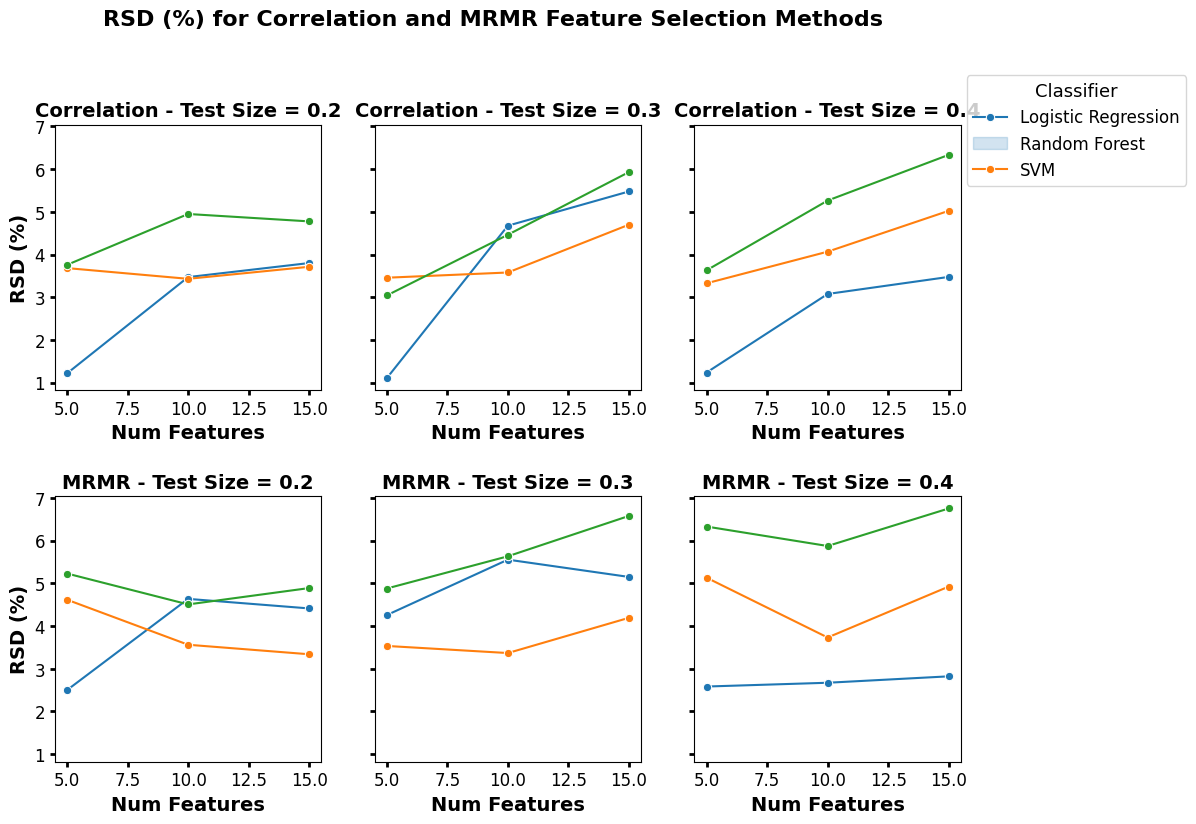

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(11.69, 8.27), sharey=True)  # A4 landscape size

# Common font properties for bold text
font_properties = {'fontsize': 14, 'fontweight': 'bold'}

# Initialize a list to store the legend handles
legend_handles = []

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    filtered_corr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'Correlation')]
    pivot_corr_df = filtered_corr_df.pivot_table(values='RSD (%)', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_corr_df.columns:
        lineplot = sns.lineplot(data=pivot_corr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', ax=axes[0, i])
        if i == 0:  # Only capture legend handles and labels from the first column of the first row
            legend_handles, _ = axes[0, i].get_legend_handles_labels()

    axes[0, i].set_title(f'Correlation - Test Size = {test_size}', **font_properties)
    axes[0, i].set_xlabel('Num Features', **font_properties)
    axes[0, i].set_ylabel('RSD (%)' if i == 0 else '', **font_properties)

    axes[0, i].tick_params(axis='both', which='major', labelsize=12, width=2)

    # Plotting for MRMR (second row)
    filtered_mrmr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'MRMR')]
    pivot_mrmr_df = filtered_mrmr_df.pivot_table(values='RSD (%)', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_mrmr_df.columns:
        sns.lineplot(data=pivot_mrmr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', ax=axes[1, i])

    axes[1, i].set_title(f'MRMR - Test Size = {test_size}', **font_properties)
    axes[1, i].set_xlabel('Num Features', **font_properties)
    axes[1, i].set_ylabel('RSD (%)' if i == 0 else '', **font_properties)

    axes[1, i].tick_params(axis='both', which='major', labelsize=12, width=2)

# Create a single legend for the entire figure using the captured handles and labels
fig.legend(legend_handles, labels=pivot_corr_df.columns, loc='upper right', fontsize=12, title='Classifier', title_fontsize='13', bbox_to_anchor=(1.1, 0.95))

# Adjust layout with more space between the rows
plt.subplots_adjust(hspace=0.4)  # Increase hspace to add more vertical space between rows

# Adjust the overall title position
plt.suptitle('RSD (%) for Correlation and MRMR Feature Selection Methods', y=1.02, fontsize=16, fontweight='bold')

# Save the figure in A4 format with high resolution
plt.savefig('RSD_Correlation_MRMR_A4.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


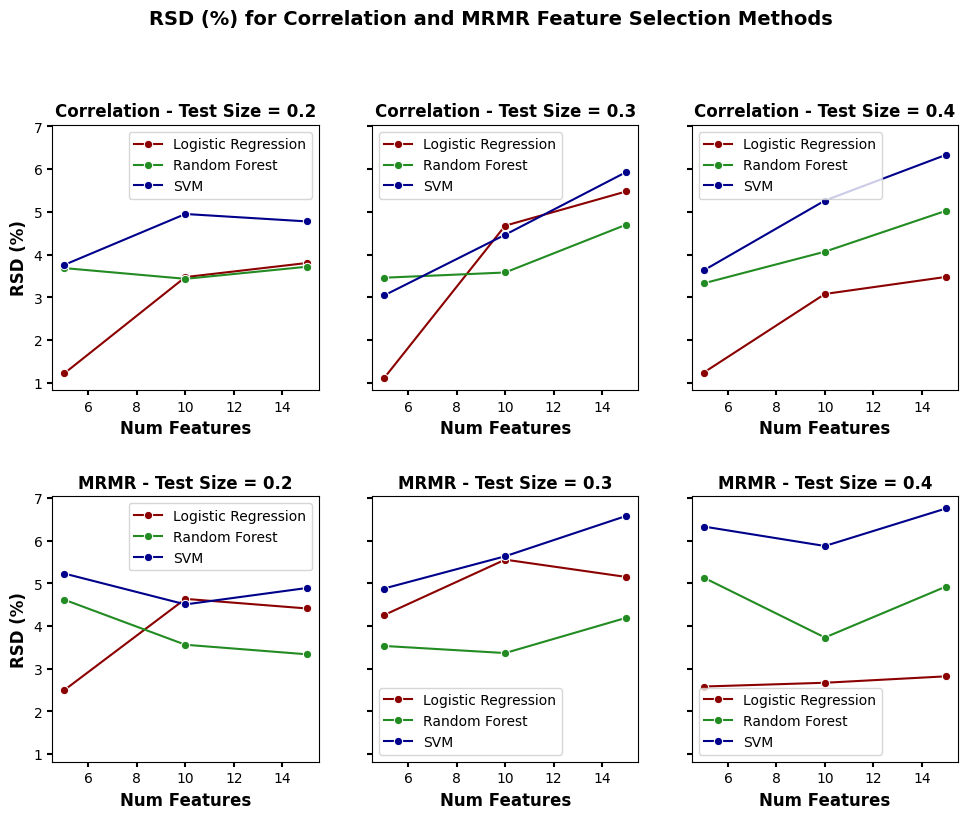

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colors for each classifier
classifier_colors = {
    'Random Forest': 'forestgreen',
    'SVM': 'darkblue',
    'Logistic Regression': 'darkred'
}

# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(11.69, 8.27), sharey=True)  # A4 landscape size

# Common font properties for smaller, bold text
font_properties = {'fontsize': 12, 'fontweight': 'bold'}  # Reduced fontsize

# Initialize a dictionary to store the legend handles and labels
legend_handles_labels = {}

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    filtered_corr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'Correlation')]
    pivot_corr_df = filtered_corr_df.pivot_table(values='RSD (%)', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_corr_df.columns:
        lineplot = sns.lineplot(
            data=pivot_corr_df[classifier].reset_index(),
            x='Num Features',
            y=classifier,
            marker='o',
            ax=axes[0, i],
            color=classifier_colors[classifier],
            label=classifier  # Use label to capture the classifier name
        )
        if classifier not in legend_handles_labels:  # Capture one handle per classifier
            legend_handles_labels[classifier] = lineplot.get_lines()[-1]

    axes[0, i].set_title(f'Correlation - Test Size = {test_size}', **font_properties)
    axes[0, i].set_xlabel('Num Features', **font_properties)
    axes[0, i].set_ylabel('RSD (%)' if i == 0 else '', **font_properties)

    axes[0, i].tick_params(axis='both', which='major', labelsize=10, width=1.5)  # Reduced tick label size

    # Plotting for MRMR (second row)
    filtered_mrmr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'MRMR')]
    pivot_mrmr_df = filtered_mrmr_df.pivot_table(values='RSD (%)', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_mrmr_df.columns:
        sns.lineplot(
            data=pivot_mrmr_df[classifier].reset_index(),
            x='Num Features',
            y=classifier,
            marker='o',
            ax=axes[1, i],
            color=classifier_colors[classifier],
            label=classifier  # Use label to capture the classifier name
        )

    axes[1, i].set_title(f'MRMR - Test Size = {test_size}', **font_properties)
    axes[1, i].set_xlabel('Num Features', **font_properties)
    axes[1, i].set_ylabel('RSD (%)' if i == 0 else '', **font_properties)

    axes[1, i].tick_params(axis='both', which='major', labelsize=10, width=1.5)  # Reduced tick label size

# Adjust layout with more space between the rows
plt.subplots_adjust(hspace=0.4)  # Increase hspace to add more vertical space between rows

# Adjust the overall title position
plt.suptitle('RSD (%) for Correlation and MRMR Feature Selection Methods', y=1.02, fontsize=14, fontweight='bold')  # Reduced suptitle fontsize

# Save the figure in A4 format with high resolution
plt.savefig('RSD_Correlation_MRMR_A4.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



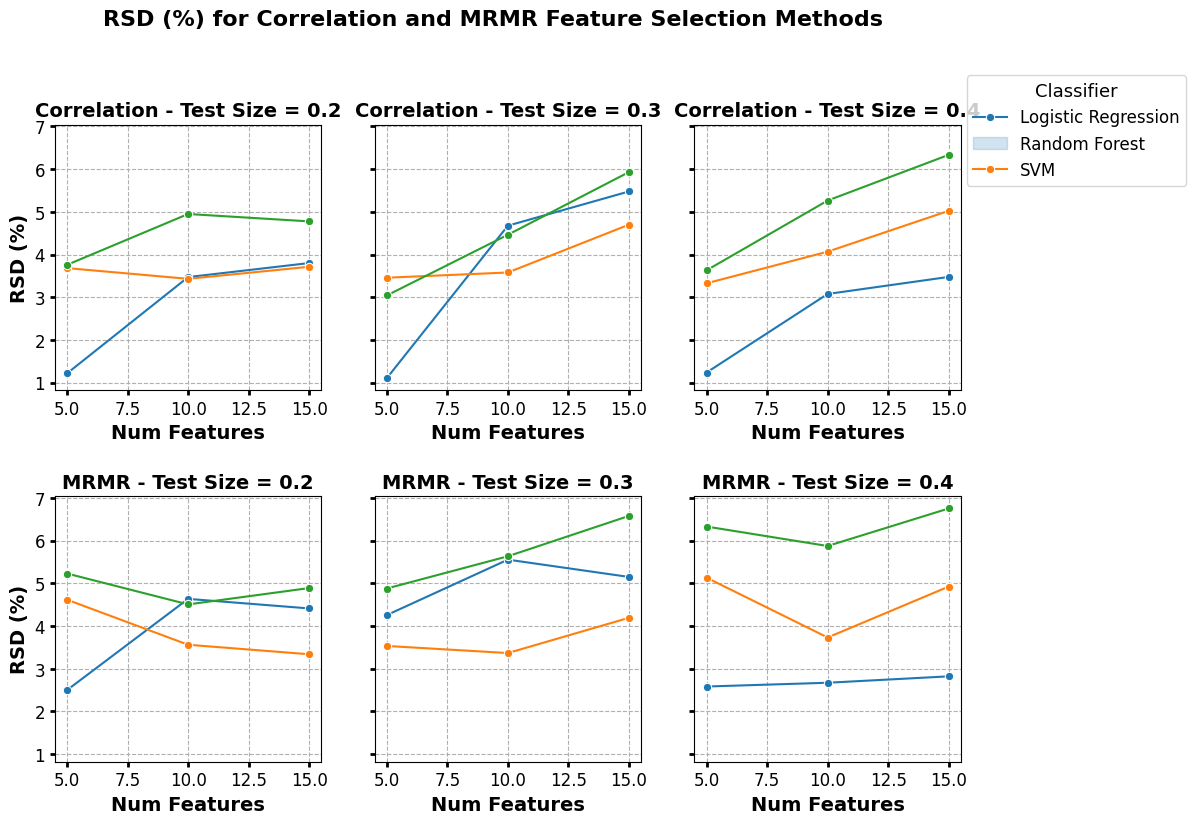

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(11.69, 8.27), sharey=True)  # A4 landscape size

# Common font properties for bold text
font_properties = {'fontsize': 14, 'fontweight': 'bold'}

# Initialize a list to store the legend handles
legend_handles = []

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    filtered_corr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'Correlation')]
    pivot_corr_df = filtered_corr_df.pivot_table(values='RSD (%)', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_corr_df.columns:
        lineplot = sns.lineplot(data=pivot_corr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', ax=axes[0, i])
        if i == 0:  # Only capture legend handles and labels from the first column of the first row
            legend_handles, _ = axes[0, i].get_legend_handles_labels()

    axes[0, i].set_title(f'Correlation - Test Size = {test_size}', **font_properties)
    axes[0, i].set_xlabel('Num Features', **font_properties)
    axes[0, i].set_ylabel('RSD (%)' if i == 0 else '', **font_properties)
    axes[0, i].grid(True, linestyle='--')
    axes[0, i].tick_params(axis='both', which='major', labelsize=12, width=2)

    # Plotting for MRMR (second row)
    filtered_mrmr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'MRMR')]
    pivot_mrmr_df = filtered_mrmr_df.pivot_table(values='RSD (%)', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_mrmr_df.columns:
        sns.lineplot(data=pivot_mrmr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', ax=axes[1, i])

    axes[1, i].set_title(f'MRMR - Test Size = {test_size}', **font_properties)
    axes[1, i].set_xlabel('Num Features', **font_properties)
    axes[1, i].set_ylabel('RSD (%)' if i == 0 else '', **font_properties)
    axes[1, i].grid(True, linestyle='--')
    axes[1, i].tick_params(axis='both', which='major', labelsize=12, width=2)

# Create a single legend for the entire figure using the captured handles and labels
fig.legend(legend_handles, labels=pivot_corr_df.columns, loc='upper right', fontsize=12, title='Classifier', title_fontsize='13', bbox_to_anchor=(1.1, 0.95))

# Adjust layout with more space between the rows
plt.subplots_adjust(hspace=0.4)  # Increase hspace to add more vertical space between rows

# Adjust the overall title position
plt.suptitle('RSD (%) for Correlation and MRMR Feature Selection Methods', y=1.02, fontsize=16, fontweight='bold')

# Save the figure in A4 format with high resolution
plt.savefig('RSD_Correlation_MRMR_A4.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
# Optional: Save the RSD results to a CSV file
rsd_df.to_csv('/content/drive/MyDrive/dataset1feature_selection_stenosis_rsd_results.csv', index=False)

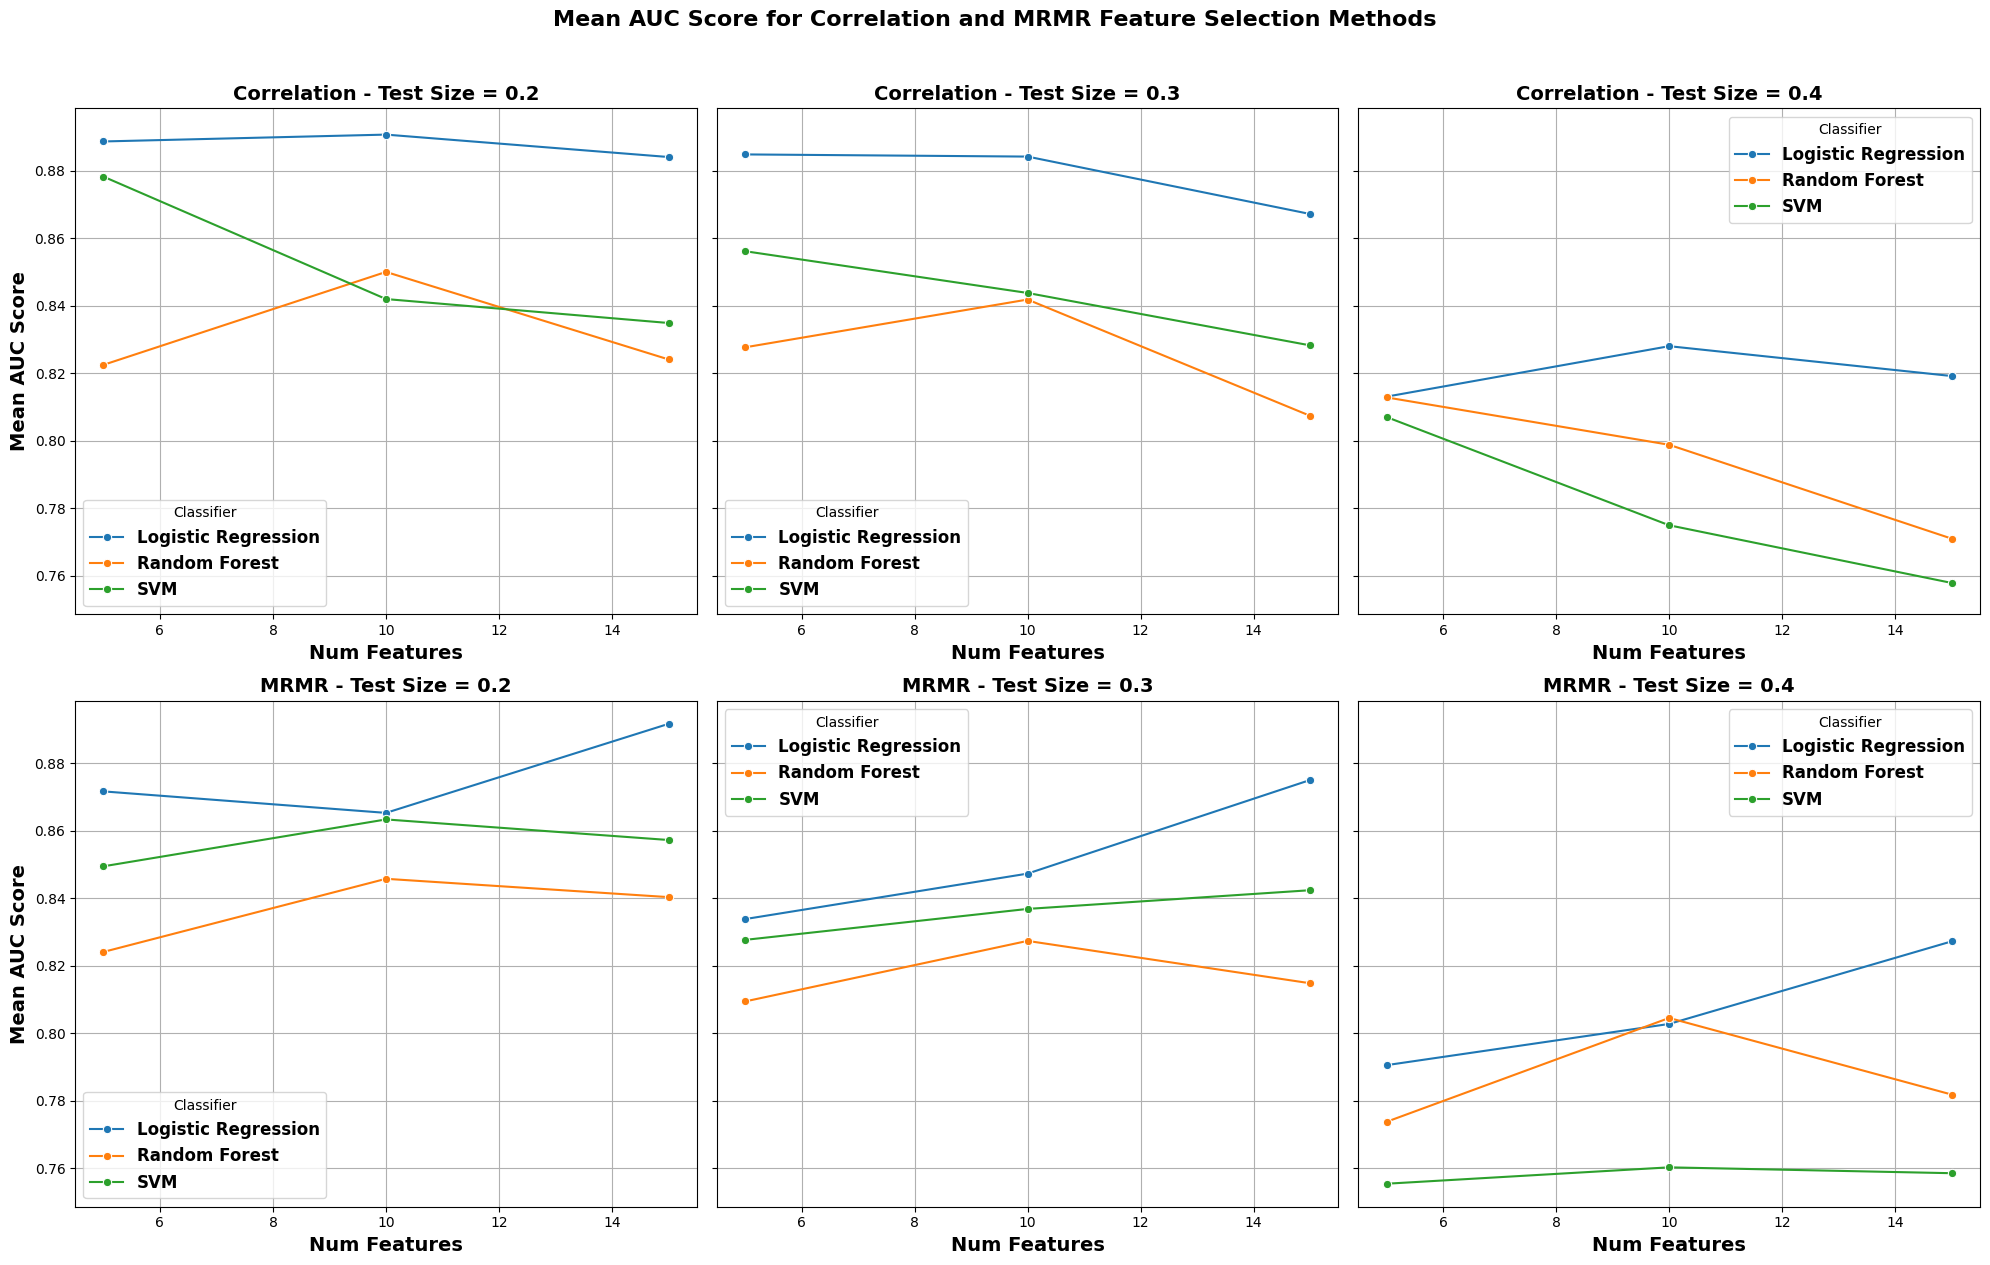

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(20, 12), sharey=True)

# Common font properties
font_properties = {'fontsize': 14, 'fontweight': 'bold', 'fontname': 'Arial'}

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    filtered_corr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'Correlation')]
    pivot_corr_df = filtered_corr_df.pivot_table(values='AUC Mean', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_corr_df.columns:
        sns.lineplot(data=pivot_corr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', label=classifier, ax=axes[0, i])

    axes[0, i].set_title(f'Correlation - Test Size = {test_size}', **font_properties)
    axes[0, i].set_xlabel('Num Features', **font_properties)
    axes[0, i].set_ylabel('Mean AUC Score' if i == 0 else '', **font_properties)
    axes[0, i].legend(title='Classifier', prop={'size': 12, 'weight': 'bold'})
    axes[0, i].grid(True)

    # Plotting for MRMR (second row)
    filtered_mrmr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'MRMR')]
    pivot_mrmr_df = filtered_mrmr_df.pivot_table(values='AUC Mean', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_mrmr_df.columns:
        sns.lineplot(data=pivot_mrmr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', label=classifier, ax=axes[1, i])

    axes[1, i].set_title(f'MRMR - Test Size = {test_size}', **font_properties)
    axes[1, i].set_xlabel('Num Features', **font_properties)
    axes[1, i].set_ylabel('Mean AUC Score' if i == 0 else '', **font_properties)
    axes[1, i].legend(title='Classifier', prop={'size': 12, 'weight': 'bold'})
    axes[1, i].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle('Mean AUC Score for Correlation and MRMR Feature Selection Methods', y=1.05, fontsize=16, fontweight='bold', fontname='Arial')
plt.show()


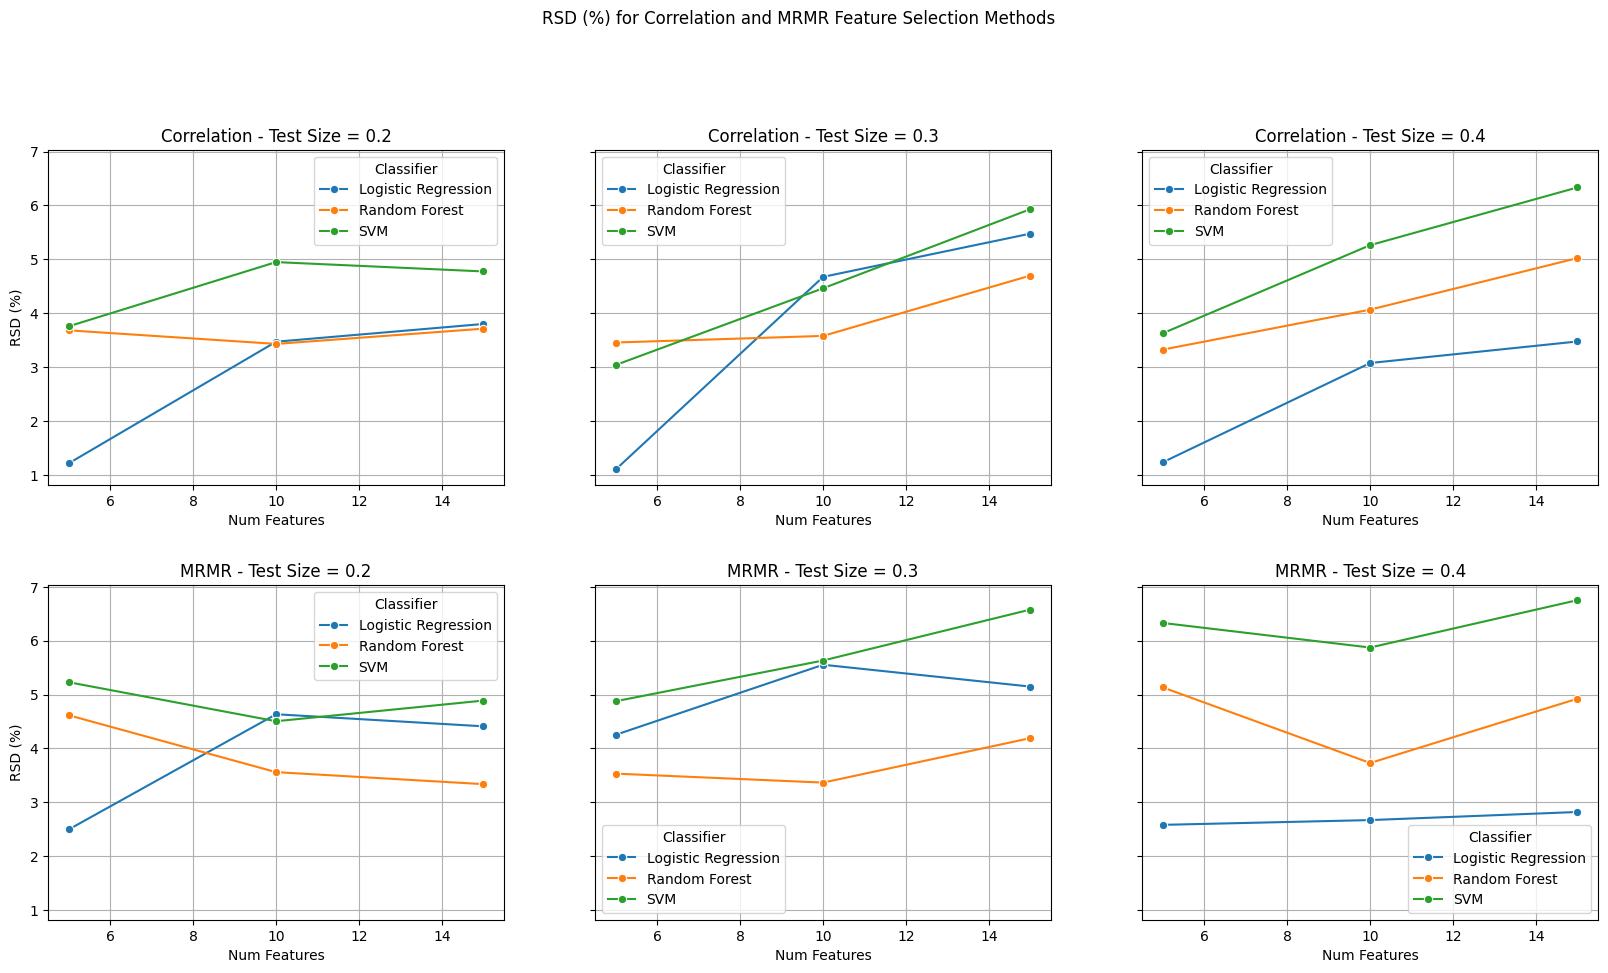

In [ ]:
# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(20, 10), sharey=True)

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    filtered_corr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'Correlation')]
    pivot_corr_df = filtered_corr_df.pivot_table(values='RSD (%)', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_corr_df.columns:
        sns.lineplot(data=pivot_corr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', label=classifier, ax=axes[0, i])

    axes[0, i].set_title(f'Correlation - Test Size = {test_size}')
    axes[0, i].set_xlabel('Num Features')
    axes[0, i].set_ylabel('RSD (%)' if i == 0 else '', )
    axes[0, i].legend(title='Classifier')
    axes[0, i].grid(True)

    # Plotting for MRMR (second row)
    filtered_mrmr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'MRMR')]
    pivot_mrmr_df = filtered_mrmr_df.pivot_table(values='RSD (%)', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_mrmr_df.columns:
        sns.lineplot(data=pivot_mrmr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', label=classifier, ax=axes[1, i])

    axes[1, i].set_title(f'MRMR - Test Size = {test_size}')
    axes[1, i].set_xlabel('Num Features')
    axes[1, i].set_ylabel('RSD (%)' if i == 0 else '')
    axes[1, i].legend(title='Classifier')
    axes[1, i].grid(True)

# Adjust layout with more space between the rows
plt.subplots_adjust(hspace=0.3)  # Increase hspace to add more vertical space between rows

# Adjust the overall title position
plt.suptitle('RSD (%) for Correlation and MRMR Feature Selection Methods', y=1.02)

# Show the plot
plt.show()

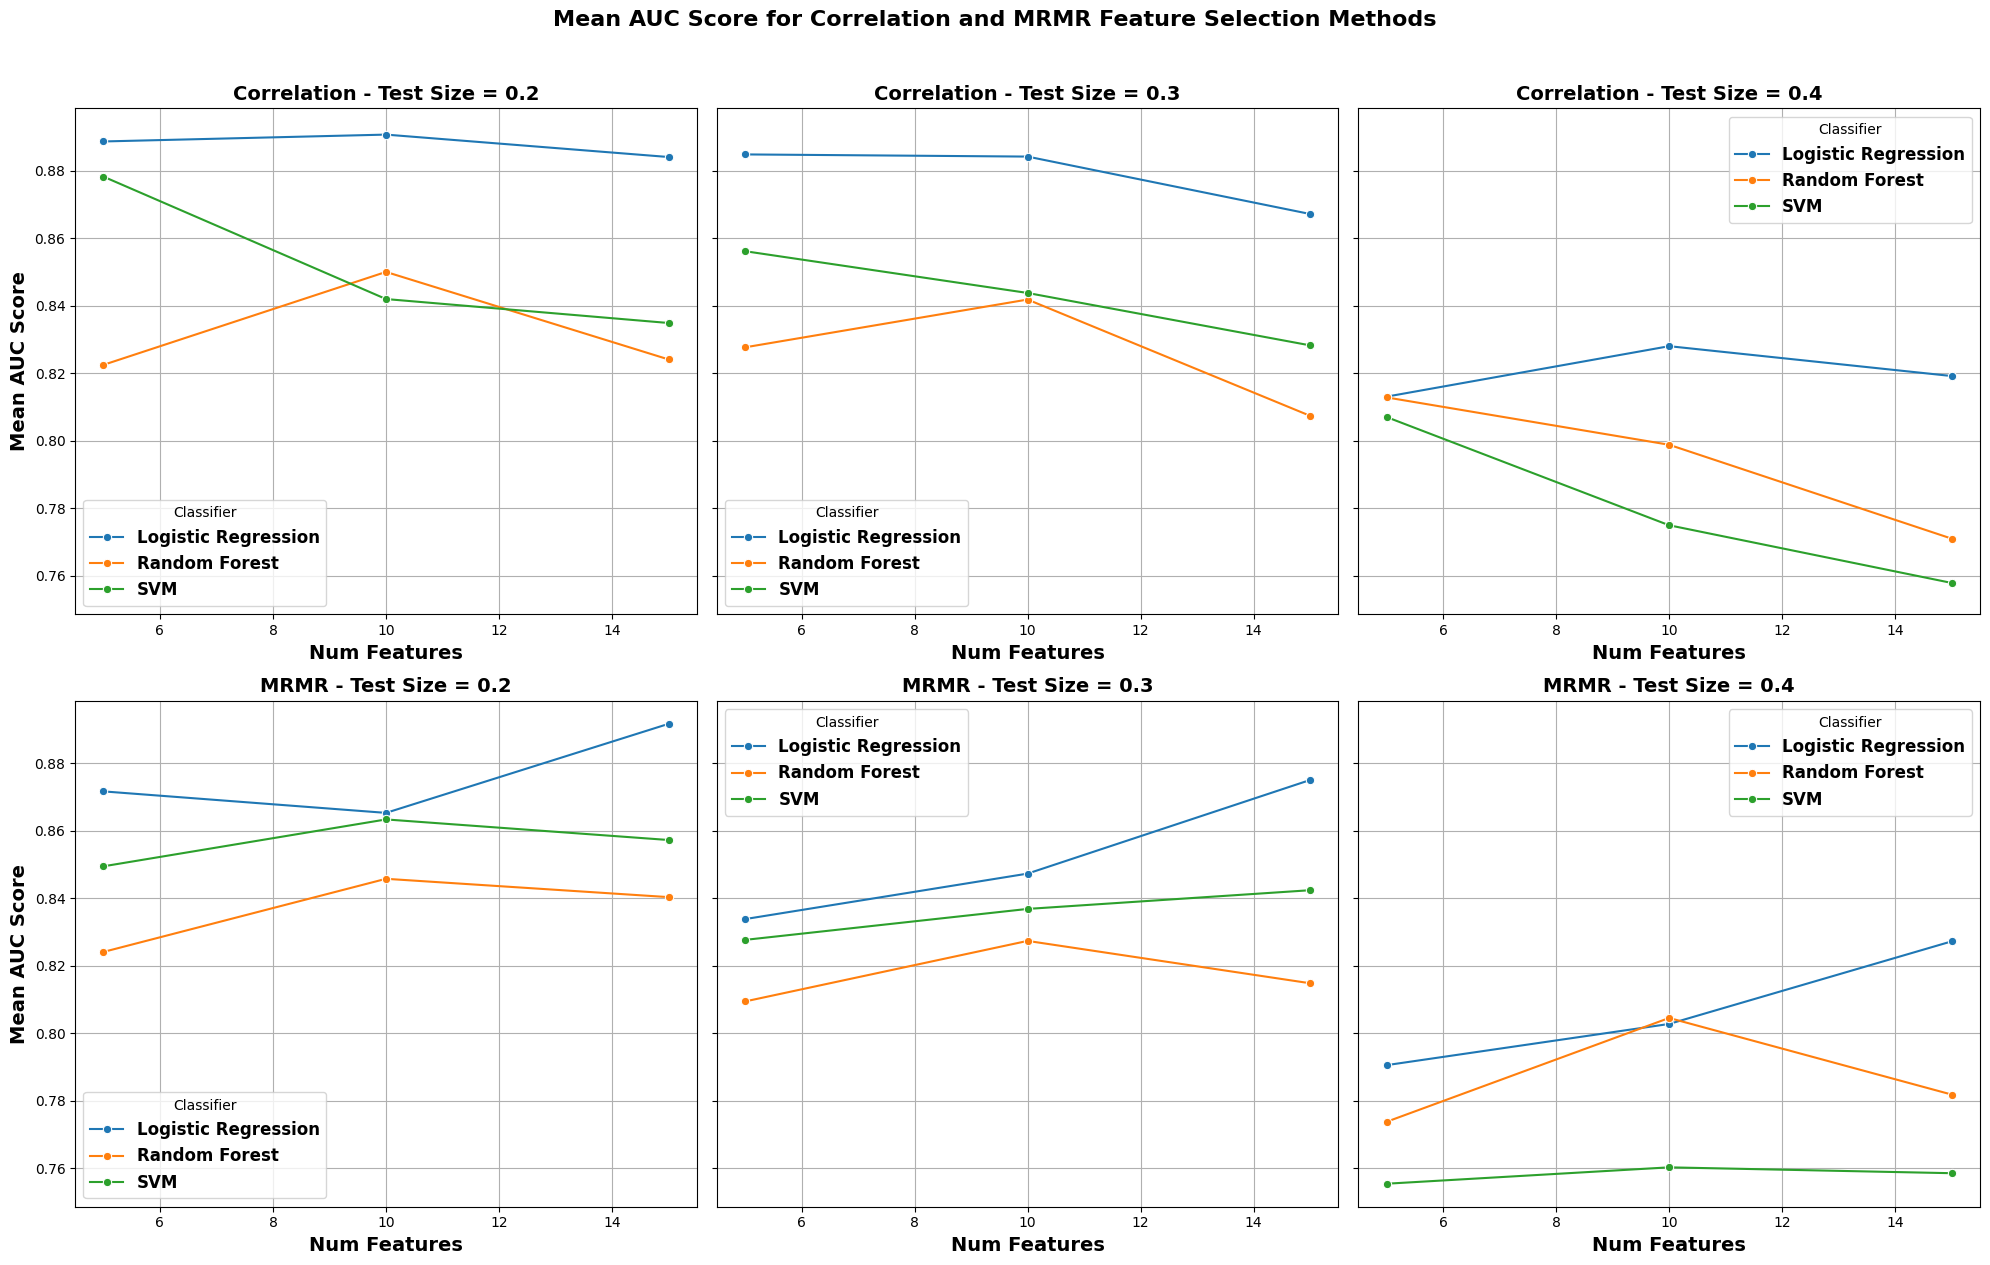

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(20, 12), sharey=True)

# Common font properties
font_properties = {'fontsize': 14, 'fontweight': 'bold'}

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    filtered_corr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'Correlation')]
    pivot_corr_df = filtered_corr_df.pivot_table(values='AUC Mean', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_corr_df.columns:
        sns.lineplot(data=pivot_corr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', label=classifier, ax=axes[0, i])

    axes[0, i].set_title(f'Correlation - Test Size = {test_size}', **font_properties)
    axes[0, i].set_xlabel('Num Features', **font_properties)
    axes[0, i].set_ylabel('Mean AUC Score' if i == 0 else '', **font_properties)
    axes[0, i].legend(title='Classifier', prop={'size': 12, 'weight': 'bold'})
    axes[0, i].grid(True)

    # Plotting for MRMR (second row)
    filtered_mrmr_df = rsd_df[(rsd_df['Test Size'] == test_size) & (rsd_df['Feature Selection'] == 'MRMR')]
    pivot_mrmr_df = filtered_mrmr_df.pivot_table(values='AUC Mean', index=['Feature Selection', 'Num Features'], columns='Classifier')

    for classifier in pivot_mrmr_df.columns:
        sns.lineplot(data=pivot_mrmr_df[classifier].reset_index(), x='Num Features', y=classifier, marker='o', label=classifier, ax=axes[1, i])

    axes[1, i].set_title(f'MRMR - Test Size = {test_size}', **font_properties)
    axes[1, i].set_xlabel('Num Features', **font_properties)
    axes[1, i].set_ylabel('Mean AUC Score' if i == 0 else '', **font_properties)
    axes[1, i].legend(title='Classifier', prop={'size': 12, 'weight': 'bold'})
    axes[1, i].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle('Mean AUC Score for Correlation and MRMR Feature Selection Methods', y=1.05, fontsize=16, fontweight='bold', fontname='Arial')
plt.show()


100%|██████████| 10/10 [00:00<00:00, 37.69it/s]


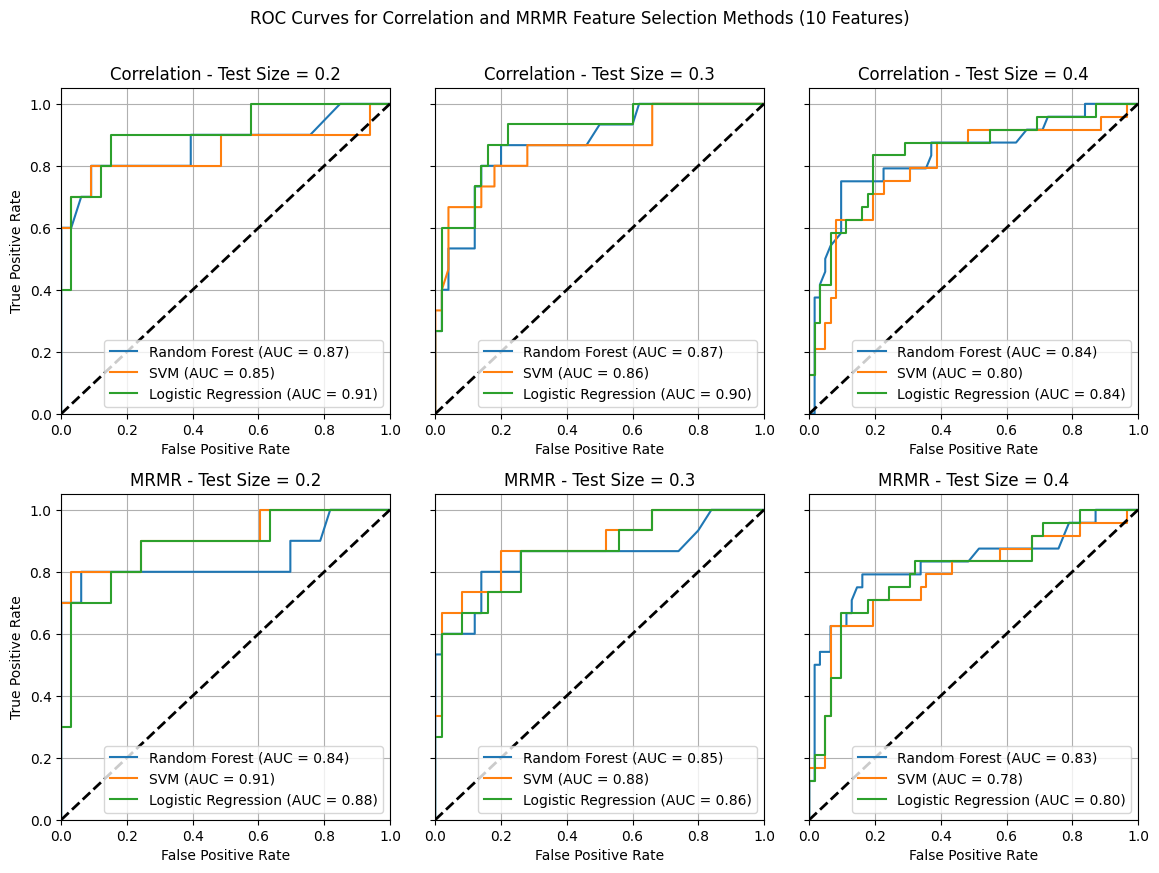

In [ ]:
# Step 10: Prepare data for visualization and plot 6 graphs in two rows based on ROC curves for 10 features only
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colors for each classifier
classifier_colors = {
    'Random Forest': 'forestgreen',
    'SVM': 'darkblue',
    'Logistic Regression': 'darkred'
}

# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(11.69, 8.27), sharey=True)  # A4 landscape size

# Common font properties for smaller, bold text
font_properties = {'fontsize': 12, 'fontweight': 'bold'}  # Reduced fontsize

# Initialize a dictionary to store the legend handles and labels
legend_handles_labels = {}

# Set the range for x-axis (Num Features) based on increments of 5
x_ticks = range(5, 20, 5)  # Adjust according to the feature numbers you're working with
# Set the number of features to 10
k = 10

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    X_selected_corr, selected_feature_names_corr = correlation_selector(X, y, k)
    X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_selected_corr, y, test_size=test_size, random_state=42)

    for clf_name, clf in classifiers.items():

        clf.fit(X_train_corr, y_train_corr)
        y_pred_prob_corr = clf.predict_proba(X_test_corr)[:, 1]

        # Compute ROC curve and AUC
        fpr_corr, tpr_corr, _ = roc_curve(y_test_corr, y_pred_prob_corr)
        roc_auc_corr = auc(fpr_corr, tpr_corr)

        # Plot ROC curve
        axes[0, i].plot(fpr_corr, tpr_corr, label=f'{clf_name} (AUC = {roc_auc_corr:.2f})')

    axes[0, i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_title(f'Correlation - Test Size = {test_size}')
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate' if i == 0 else '')
    axes[0, i].legend(loc="lower right")
    axes[0, i].grid(True)

    # Plotting for MRMR (second row)
    X_selected_mrmr, selected_feature_names_mrmr = mrmr_selector(X, y, k)
    X_train_mrmr, X_test_mrmr, y_train_mrmr, y_test_mrmr = train_test_split(X_selected_mrmr, y, test_size=test_size, random_state=42)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_mrmr, y_train_mrmr)
        y_pred_prob_mrmr = clf.predict_proba(X_test_mrmr)[:, 1]

        # Compute ROC curve and AUC
        fpr_mrmr, tpr_mrmr, _ = roc_curve(y_test_mrmr, y_pred_prob_mrmr)
        roc_auc_mrmr = auc(fpr_mrmr, tpr_mrmr)

        # Plot ROC curve
        axes[1, i].plot(fpr_mrmr, tpr_mrmr, label=f'{clf_name} (AUC = {roc_auc_mrmr:.2f})')

    axes[1, i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_title(f'MRMR - Test Size = {test_size}')
    axes[1, i].set_xlabel('False Positive Rate')
    axes[1, i].set_ylabel('True Positive Rate' if i == 0 else '')
    axes[1, i].legend(loc="lower right")
    axes[1, i].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle('ROC Curves for Correlation and MRMR Feature Selection Methods (10 Features)', y=1.05)
plt.show()


100%|██████████| 10/10 [00:00<00:00, 39.58it/s]


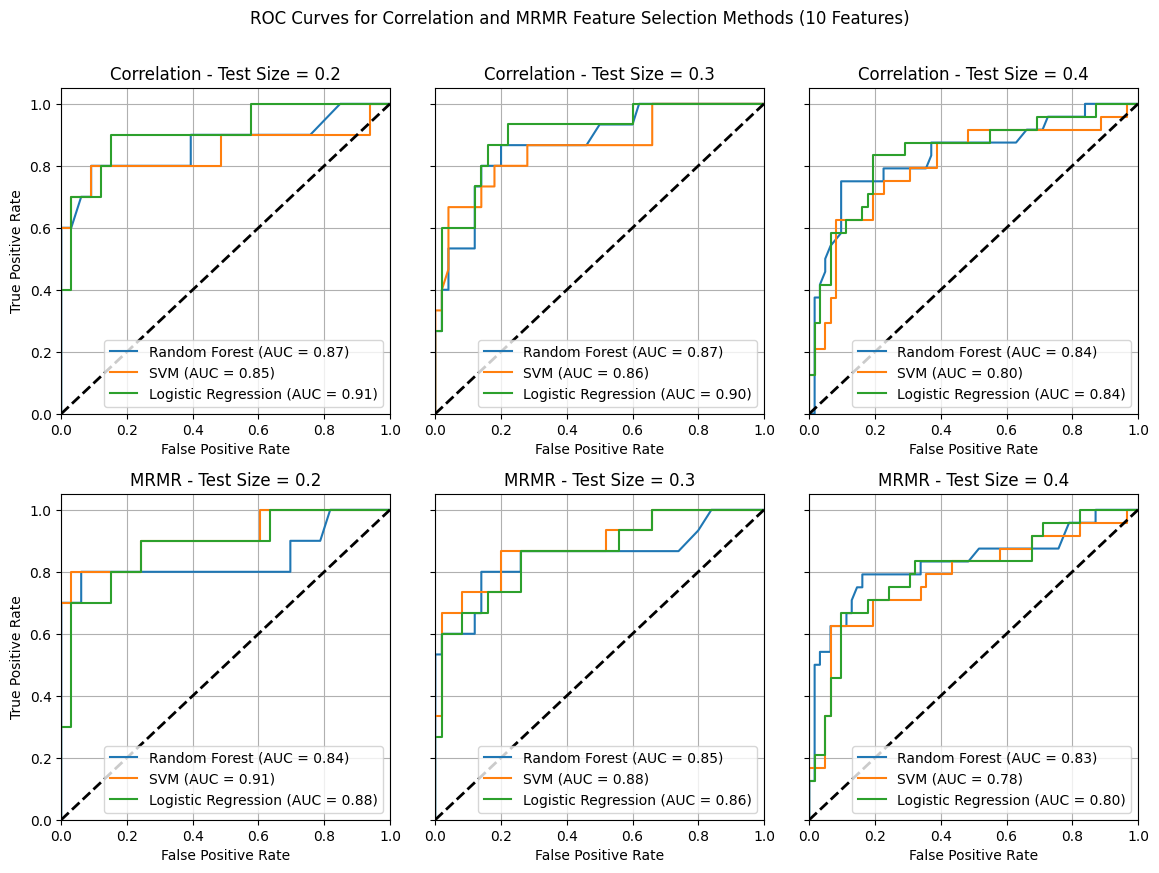

In [ ]:
# Step 10: Prepare data for visualization and plot 6 graphs in two rows based on ROC curves for 10 features only
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colors for each classifier
classifier_colors = {
    'Random Forest': 'forestgreen',
    'SVM': 'darkblue',
    'Logistic Regression': 'darkred'
}

# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(11.69, 8.27), sharey=True)  # A4 landscape size

# Common font properties for smaller, bold text
font_properties = {'fontsize': 12, 'fontweight': 'bold'}  # Reduced fontsize

# Initialize a dictionary to store the legend handles and labels
legend_handles_labels = {}

# Set the range for x-axis (Num Features) based on increments of 5
x_ticks = range(5, 20, 5)  # Adjust according to the feature numbers you're working with
# Set the number of features to 10
k = 10

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    X_selected_corr, selected_feature_names_corr = correlation_selector(X, y, k)
    X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_selected_corr, y, test_size=test_size, random_state=42)

    for clf_name, clf in classifiers.items():

        clf.fit(X_train_corr, y_train_corr)
        y_pred_prob_corr = clf.predict_proba(X_test_corr)[:, 1]

        # Compute ROC curve and AUC
        fpr_corr, tpr_corr, _ = roc_curve(y_test_corr, y_pred_prob_corr)
        roc_auc_corr = auc(fpr_corr, tpr_corr)

        # Plot ROC curve
        axes[0, i].plot(fpr_corr, tpr_corr, label=f'{clf_name} (AUC = {roc_auc_corr:.2f})')

    axes[0, i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_title(f'Correlation - Test Size = {test_size}')
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate' if i == 0 else '')
    axes[0, i].legend(loc="lower right")
    axes[0, i].grid(True)

    # Plotting for MRMR (second row)
    X_selected_mrmr, selected_feature_names_mrmr = mrmr_selector(X, y, k)
    X_train_mrmr, X_test_mrmr, y_train_mrmr, y_test_mrmr = train_test_split(X_selected_mrmr, y, test_size=test_size, random_state=42)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_mrmr, y_train_mrmr)
        y_pred_prob_mrmr = clf.predict_proba(X_test_mrmr)[:, 1]

        # Compute ROC curve and AUC
        fpr_mrmr, tpr_mrmr, _ = roc_curve(y_test_mrmr, y_pred_prob_mrmr)
        roc_auc_mrmr = auc(fpr_mrmr, tpr_mrmr)

        # Plot ROC curve
        axes[1, i].plot(fpr_mrmr, tpr_mrmr, label=f'{clf_name} (AUC = {roc_auc_mrmr:.2f})')

    axes[1, i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_title(f'MRMR - Test Size = {test_size}')
    axes[1, i].set_xlabel('False Positive Rate')
    axes[1, i].set_ylabel('True Positive Rate' if i == 0 else '')
    axes[1, i].legend(loc="lower right")
    axes[1, i].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle('ROC Curves for Correlation and MRMR Feature Selection Methods (10 Features)', y=1.05)
plt.show()


100%|██████████| 10/10 [00:00<00:00, 24.30it/s]


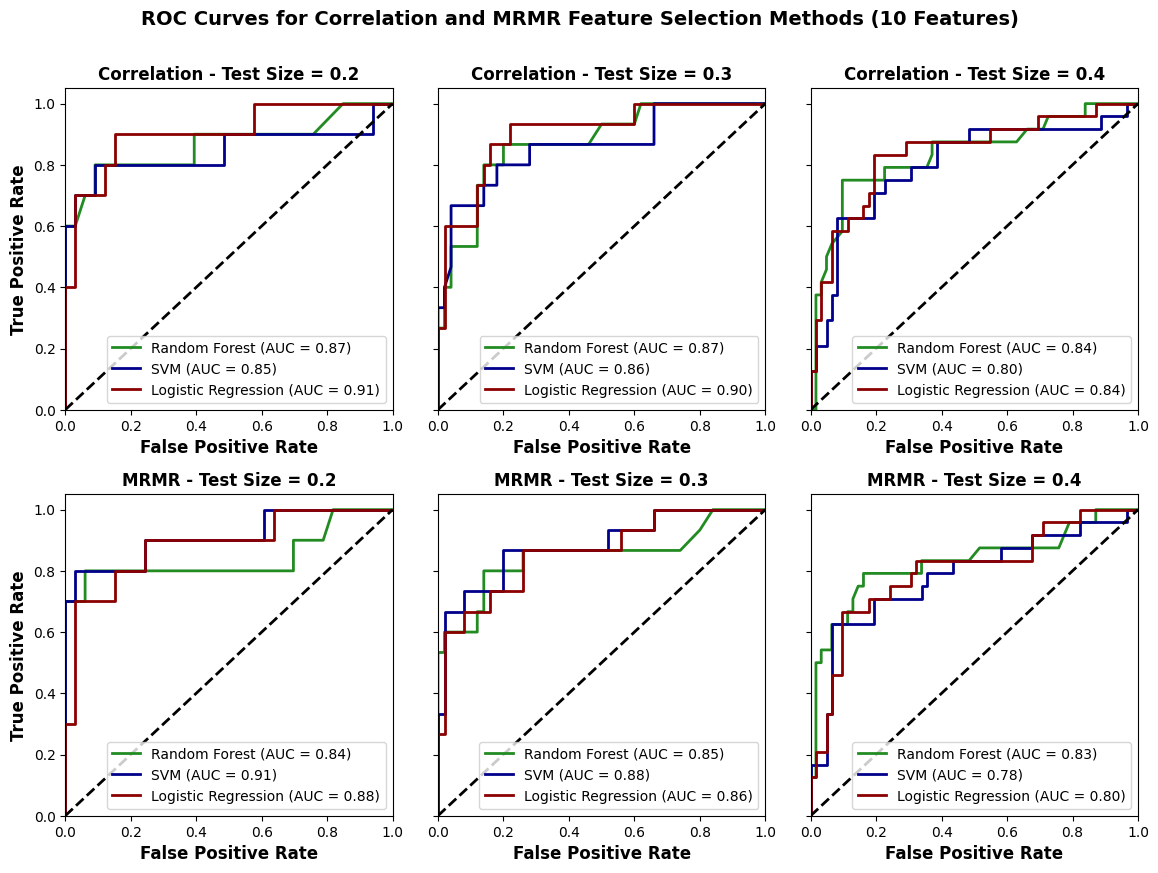

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colors for each classifier
classifier_colors = {
    'Random Forest': 'forestgreen',
    'SVM': 'darkblue',
    'Logistic Regression': 'darkred'
}

# Step 10: Prepare data for visualization and plot 6 graphs in two rows
fig, axes = plt.subplots(2, len(test_sizes), figsize=(11.69, 8.27), sharey=True)  # A4 landscape size

# Common font properties for smaller, bold text
font_properties = {'fontsize': 12, 'fontweight': 'bold'}  # Reduced fontsize

# Set the number of features to 10
k = 10

# Step 11: Loop through each test size and create a subplot for each in the appropriate row
for i, test_size in enumerate(test_sizes):
    # Plotting for Correlation (first row)
    X_selected_corr, selected_feature_names_corr = correlation_selector(X, y, k)
    X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_selected_corr, y, test_size=test_size, random_state=42)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_corr, y_train_corr)
        y_pred_prob_corr = clf.predict_proba(X_test_corr)[:, 1]

        # Compute ROC curve and AUC
        fpr_corr, tpr_corr, _ = roc_curve(y_test_corr, y_pred_prob_corr)
        roc_auc_corr = auc(fpr_corr, tpr_corr)

        # Plot ROC curve with specific colors for each classifier
        axes[0, i].plot(fpr_corr, tpr_corr, color=classifier_colors[clf_name], lw=2, label=f'{clf_name} (AUC = {roc_auc_corr:.2f})')

    axes[0, i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_title(f'Correlation - Test Size = {test_size}', **font_properties)
    axes[0, i].set_xlabel('False Positive Rate', **font_properties)
    axes[0, i].set_ylabel('True Positive Rate' if i == 0 else '', **font_properties)
    axes[0, i].legend(loc="lower right")


    # Plotting for MRMR (second row)
    X_selected_mrmr, selected_feature_names_mrmr = mrmr_selector(X, y, k)
    X_train_mrmr, X_test_mrmr, y_train_mrmr, y_test_mrmr = train_test_split(X_selected_mrmr, y, test_size=test_size, random_state=42)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_mrmr, y_train_mrmr)
        y_pred_prob_mrmr = clf.predict_proba(X_test_mrmr)[:, 1]

        # Compute ROC curve and AUC
        fpr_mrmr, tpr_mrmr, _ = roc_curve(y_test_mrmr, y_pred_prob_mrmr)
        roc_auc_mrmr = auc(fpr_mrmr, tpr_mrmr)

        # Plot ROC curve with specific colors for each classifier
        axes[1, i].plot(fpr_mrmr, tpr_mrmr, color=classifier_colors[clf_name], lw=2, label=f'{clf_name} (AUC = {roc_auc_mrmr:.2f})')

    axes[1, i].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_title(f'MRMR - Test Size = {test_size}', **font_properties)
    axes[1, i].set_xlabel('False Positive Rate', **font_properties)
    axes[1, i].set_ylabel('True Positive Rate' if i == 0 else '', **font_properties)
    axes[1, i].legend(loc="lower right")


# Adjust layout
plt.tight_layout()
plt.suptitle('ROC Curves for Correlation and MRMR Feature Selection Methods (10 Features)', y=1.05, fontsize=14, fontweight='bold')
plt.show()
